In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# read the plain text file located at the indicated filepath (fp)
fp = r"data/2315676.txt"
data = pd.read_csv(fp, sep = '\s+', skiprows = [1], na_values = -9999)

# define function to convert daily average temperatures from Fahrenheit to Celsius degrees
def fahr_to_cels(temp):
    temp = (temp - 32) * (5/9)
    return temp 
    
# create a new column, 'TF_daily', which contains daily average temperatures in Fahrenheit for all rows, including those that previously had missing values. 
data['TF_daily'] = data['TAVG']

data.loc[data['TAVG'].isna() & data['TMIN'].notna() & data['TMAX'].notna(), 'TF_daily'] = (data['TMIN'] + data['TMAX']) / 2
data['TF_daily'] = data['TF_daily'].combine_first(data['TMIN']).combine_first(data['TMAX'])

#convert temperatures to Celsius
data['TC_daily'] = fahr_to_cels(data['TF_daily'])

In [20]:
# create a new column, 'YEARMO', which contains a truncated version of the date for each row--YYYYMM.
data['YEARMO'] = data['DATE'].astype(str).str[:-2]

# group the rows by month and calculate monthly average temperatures into a new dataframe named 'monthly_data'
grouped = data.groupby('YEARMO')
monthly_data = pd.DataFrame(columns = ['TAVG_C'])
monthly_data['TAVG_C'] = grouped['TC_daily'].mean()
monthly_data.index = pd.to_datetime(monthly_data.index, format = '%Y%m')

In [21]:
# creating new, empty dataframes for each of the seasons
winter = pd.DataFrame(columns = ['YEAR', 'TAVG'])
spring = pd.DataFrame(columns = ['YEAR', 'TAVG'])
summer = pd.DataFrame(columns = ['YEAR', 'TAVG'])
fall = pd.DataFrame(columns = ['YEAR', 'TAVG'])

# using a for loop iterating over every year in the dataset, aggregate the monthly data into average seasonal 
# temperature data which is compiled into the 4 different dataframes. 
year = 1909

for i in range(monthly_data.index.year.nunique() - 1):

    # Monthly data is identified based on the datetime index, using the .year and .month properties. 
    
    # the data for the winter of each year contains the average temperature from December of the previous year as well as January and February of the current year
    winter_rows = monthly_data.loc[((monthly_data.index.year == year - 1) & (monthly_data.index.month == 12)) | 
        ((monthly_data.index.year == year) & (monthly_data.index.month.isin([1, 2])))]
    avg_winter = winter_rows['TAVG_C'].mean() 
    new_winter = pd.DataFrame({'YEAR' : [year], 'TAVG': [avg_winter]})
    winter = pd.concat([winter, new_winter], ignore_index = True)

    # spring data includes temps from the months of March, April, and May
    spring_rows = monthly_data.loc[(monthly_data.index.year == year) & (monthly_data.index.month.isin([3, 4, 5]))]
    avg_spring = spring_rows['TAVG_C'].mean()
    new_spring = pd.DataFrame({'YEAR' : [year], 'TAVG': [avg_spring]})
    spring = pd.concat([spring, new_spring], ignore_index = True)

    # summer data includes temps from the months of June, July, and August
    summer_rows = monthly_data.loc[(monthly_data.index.year == year) & (monthly_data.index.month.isin([6, 7, 8]))]
    avg_summer = summer_rows['TAVG_C'].mean()
    new_summer = pd.DataFrame({'YEAR' : [year], 'TAVG': [avg_summer]})
    summer = pd.concat([summer, new_summer], ignore_index = True)

    # fall data includes temps from the months of September, October, and November
    fall_rows = monthly_data.loc[(monthly_data.index.year == year) & (monthly_data.index.month.isin([9, 10, 11]))]
    avg_fall = fall_rows['TAVG_C'].mean()
    new_fall = pd.DataFrame({'YEAR' : [year], 'TAVG': [avg_fall]})
    fall = pd.concat([fall, new_fall], ignore_index = True)
    
    year += 1

# set the values of the 'YEAR' column in each dataframe to be the index
winter = winter.set_index('YEAR')
spring = spring.set_index('YEAR')
summer = summer.set_index('YEAR')
fall = fall.set_index('YEAR')

/tmp/ipykernel_6220/3237743035.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  winter = pd.concat([winter, new_winter], ignore_index = True)
/tmp/ipykernel_6220/3237743035.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  spring = pd.concat([spring, new_spring], ignore_index = True)
/tmp/ipykernel_6220/3237743035.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

In [22]:
# creating new dataframe for select 30-year period between the years of 1951 and 1980

select_period = pd.DataFrame(columns = ['year', 'winter', 'spring', 'summer', 'fall'])

# filling in the yearly seasonal average values from the seasonal dataframes
select_period['winter'] = winter['TAVG'].loc[(winter.index >= 1951) & (winter.index < 1981)]
select_period['spring'] = spring['TAVG'].loc[(spring.index >= 1951) & (spring.index < 1981)]
select_period['summer'] = summer['TAVG'].loc[(summer.index >= 1951) & (summer.index < 1981)]
select_period['fall'] = fall['TAVG'].loc[(fall.index >= 1951) & (fall.index < 1981)]

# filling in the years from a predetermined range and setting the years as the index for the dataframe

select_period['year'] = range(1951, 1981)
select_period = select_period.set_index('year')

In [23]:
# calculating seasonal averages from the select 30-year period

winter_ref = select_period['winter'].mean()
spring_ref = select_period['spring'].mean()
summer_ref = select_period['summer'].mean()
fall_ref = select_period['fall'].mean()

# adding a new column, "anomaly" to each of the seasonal dataframes by finding the difference between the reference period average and seasonal average for each year in the dataset

winter['anomaly'] = winter_ref - winter['TAVG']
spring['anomaly'] = spring_ref - spring['TAVG']
summer['anomaly'] = summer_ref - summer['TAVG']
fall['anomaly'] = fall_ref - fall['TAVG'] 


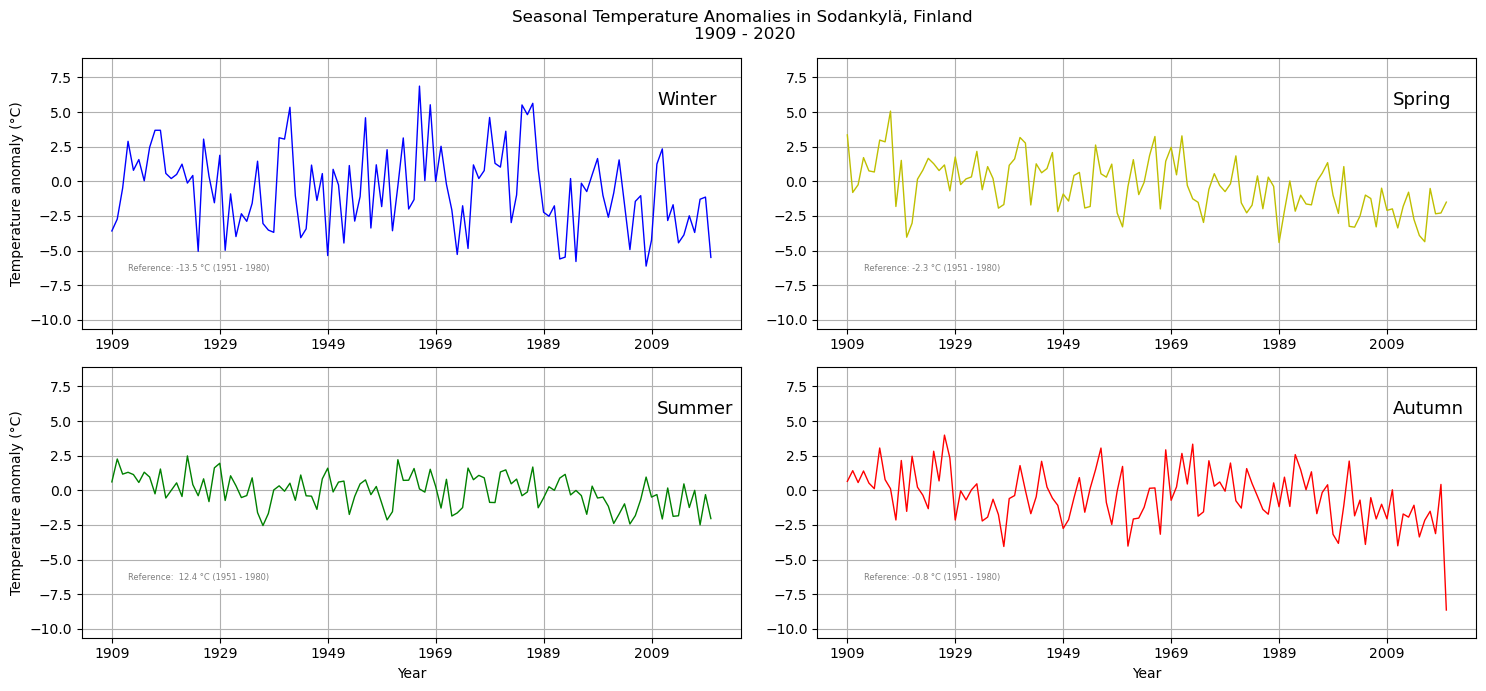

In [24]:
# determining the range of the y-axis, to accommodate data from all the seasons in a consistent format

mintemp = min(
    winter['anomaly'].min(), spring['anomaly'].min(),
    summer['anomaly'].min(), fall['anomaly'].min()
)
maxtemp = max(
    winter['anomaly'].max(), spring['anomaly'].max(),
    summer['anomaly'].max(), fall['anomaly'].max()
)
mintemp -= 2
maxtemp += 2

templim = [mintemp, maxtemp]

# formatting the subplot and the appearance of the graphs within it

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,7))

ax_winter = axs[0][0]
ax_spring = axs[0][1]
ax_summer = axs[1][0]
ax_fall = axs[1][1]

winter['anomaly'].plot(ax=ax_winter, c='b', lw = 1, ylim = templim, grid=True, ylabel = "Temperature anomaly (°C)", xlabel = "")
spring['anomaly'].plot(ax=ax_spring, c='y', lw = 1, ylim = templim, grid=True, xlabel = "", ylabel = "")
summer['anomaly'].plot(ax=ax_summer, c='g', lw = 1, ylim = templim, grid=True, ylabel = "Temperature anomaly (°C)", xlabel = "Year")
fall['anomaly'].plot(ax=ax_fall, c='r', lw = 1, ylim = templim, grid=True, xlabel = "Year", ylabel = "")

plt.suptitle('Seasonal Temperature Anomalies in Sodankylä, Finland \n1909 - 2020')

ax_winter.text(101, 5.5, "Winter", fontsize = 13)
ax_winter.text(3, -6.5, f"Reference: {winter_ref: .1f} °C (1951 - 1980)", fontsize = 6, color = "gray", bbox=dict(fc="w", ec="w"))
ax_spring.text(101, 5.5, "Spring", fontsize = 13)
ax_spring.text(3, -6.5, f"Reference: {spring_ref: .1f} °C (1951 - 1980)", fontsize = 6, color = "gray", bbox=dict(fc="w", ec="w"))
ax_summer.text(101, 5.5, "Summer", fontsize = 13)
ax_summer.text(3, -6.5, f"Reference: {summer_ref: .1f} °C (1951 - 1980)", fontsize = 6, color = "gray", bbox=dict(fc="w", ec="w"))
ax_fall.text(101, 5.5, "Autumn", fontsize = 13)
ax_fall.text(3, -6.5, f"Reference: {fall_ref: .1f} °C (1951 - 1980)", fontsize = 6, color = "gray", bbox=dict(fc="w", ec="w"))

plt.tight_layout()

# upload an image of the subplots as a png-file

plt.savefig("sodankyla_seasonal_anomalies1909-2020.png")


# Acknowledgements 

I sought advice and tips from ChatGPT 4.0 (and earlier versions when the free usage limit for version 4.0 was reached). I described what I wanted to do and asked for suggestions for fitting functions to use. I did not always use the suggestions given, but they sometimes inspired me to search for methods elsewhere. An issue I often have is that I find useful information on platforms such as the Stack Overflow or documentation pages, but the discussion of the topics is so cryptic, that I have a hard time understanding how to properly use the method suggested. 

I have not included code that was entirely generated by ChatGPT in this submission. 

Assitance was particularly useful in figuring out how to correctly assign values to the new "TF_daily" column in **cell 12**. Here (see also the line of code below) ChatGPT suggested using the *combine_first* function, which I would not have otherwise known about. ChatGPT also helped with the use of arguments in the .loc function. For example, by showing that by assigning the destination column as one of the parameters of the function, I could more or less automatically assign the new value of the column. I received this by submitting the code I had already written thus far and asking for feedback. It suggested using more (what felt like) more advanced functions from different libraries (ex. isna from the math library, lambda and apply), but I wanted to stick to using pandas' built-in functions. 

`data['TF_daily'] = data['TF_daily'].combine_first(data['TMIN']).combine_first(data['TMAX'])`

### Prompts used: 

"Using pandas and python. I want to iterate over rows in a dataframe containing temperature data. One column, TAVG, has temperature averages. There are many missing values in this column. However, there are two columns, TMIN and TMAX that I can use to calculate the average temperatures. I want to iterate over the rows and calculate averages into a new column, T_MINMAX, only for the rows where the value og TAVG is NaN. Otherwise I want the value of TAVG into the new T_MINMAX column. I would also be interested in a method that doesn't use iteration at all, but a selection through a condition using the loc function. Please present both methods." 
- *This was a prompt I used when I first started working on the assignment. I later ended up using a different approach without iterating over the rows.*

"how to use the **.concat()** function to add a row at a time to a dataframe? can you use an example" 

"how does the **combine_first** function know to extract values from the specific column in each row?"

"how does the **index.month** work? Can pandas detect the month? Is .month a function or a method?" 

"can I extract the name of a dataframe as a string" 

"how do I set the font size of text using the .text function in the matplotlib"
